Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:36:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[[14417   923]
 [ 1169   923]]
              precision    recall  f1-score   support

           0     0.9250    0.9398    0.9324     15340
           1     0.5000    0.4412    0.4688      2092

    accuracy                         0.8800     17432
   macro avg     0.7125    0.6905    0.7006     17432
weighted avg     0.8740    0.8800    0.8767     17432

✅ 최종 제출 저장 완료: submit_voting_xgbtuned.csv


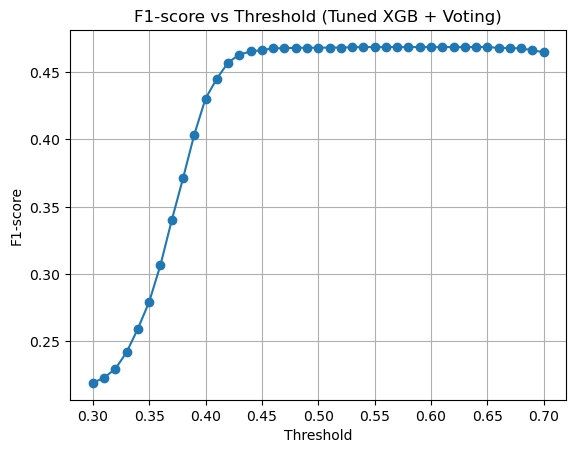

In [2]:
# 먼저 필요한 패키지 설치
# pip install xgboost lightgbm catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 데이터 로드
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

X = train.drop(columns=['ID', 'Cancer'])
y = train['Cancer']
x_test = test.drop(columns=['ID'])

# 범주형 인코딩
categorical_cols = X.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    x_test[col] = le.transform(x_test[col])

# Feature 제거
low_features = ['Gender', 'Smoke', 'Weight_Risk', 'Diabetes']
X_reduced = X.drop(columns=low_features)
x_test_reduced = x_test.drop(columns=low_features)

# Train/Validation 분할
X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.2, stratify=y, random_state=42)

# XGBoost 튜닝
param_grid = {
    'max_depth': [6],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 5, 7.3, 10, 12, 15, 20]
}
xgb_base = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
rs_xgb = RandomizedSearchCV(xgb_base, param_grid, n_iter=60, scoring=make_scorer(f1_score),
                            cv=5, n_jobs=-1, verbose=1, random_state=42)
rs_xgb.fit(X_train, y_train)
best_xgb_model = rs_xgb.best_estimator_

# CatBoost + LightGBM
cat_param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'iterations': [200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

cat_base = CatBoostClassifier(
    auto_class_weights='Balanced',
    random_seed=42,
    verbose=0
)

rs_cat = RandomizedSearchCV(
    estimator=cat_base,
    param_distributions=cat_param_grid,
    n_iter=30,
    scoring=make_scorer(f1_score),
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rs_cat.fit(X_train, y_train)
best_cat_model = rs_cat.best_estimator_
lgb_model = LGBMClassifier(random_state=42, scale_pos_weight=np.bincount(y)[0] / np.bincount(y)[1])

# Soft Voting
voting_model = VotingClassifier(
    estimators=[('cat', best_cat_model), ('lgb', lgb_model), ('xgb', best_xgb_model)],
    voting='soft', n_jobs=-1
)
voting_model.fit(X_train, y_train)

# Threshold 튜닝
y_val_proba = voting_model.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.30, 0.71, 0.01)
f1_scores = [f1_score(y_val, (y_val_proba >= t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

# 성능 평가
y_val_pred = (y_val_proba >= best_thresh).astype(int)
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, digits=4))

# 전체 데이터로 학습 후 테스트 예측
voting_model.fit(X_reduced, y)
y_test_proba = voting_model.predict_proba(x_test_reduced)[:, 1]
y_test_pred = (y_test_proba >= best_thresh).astype(int)

# 제출
submission['Cancer'] = y_test_pred
submission.to_csv('submit_voting_xgbtuned.csv', index=False)
print("✅ 최종 제출 저장 완료: submit_voting_xgbtuned.csv")

# F1-score 시각화
plt.plot(thresholds, f1_scores, marker='o')
plt.title('F1-score vs Threshold (Tuned XGB + Voting)')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.grid(True)
plt.show()